# scCODA - Power analysis

We want to explore the power of scCODA depending on the sample and effect size.
For this, we use the overall benchmark results.

We first grouped the data by the sample size, number of cell types, number of cells, base count and effect size.
We then summed up the corresponding true positive, true negative, false positive and false negative results and
calculated classification summary statistics on these sums to receive more robust estimates of the power of scCODA for each parameter setting.

In [1]:
%matplotlib inline 

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

%load_ext rpy2.ipython

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style("ticks")

First, we read the data and create some new statistics that might potentially influence the MCC:

- The log of the absolute increase
- The total number of samples and its log
- The ratio of case to control samples

We also perform min-max and logit transform of the constrained MCC to gain an unconstrained measure.


In [2]:
# read in aggregated benchmark results for power analysis 
df = pd.read_csv("../../sccoda_benchmark_data/overall_benchmark/all_results_aggregated.csv", sep=",")
df["log_increase"] = np.log(df["Increase"])
df["total_samples"] = df["n_controls"] + df["n_cases"]
df["log_total_samples"] = np.log(df["total_samples"])
df["ratio_case"] = df["n_cases"] / df["n_controls"]
df["mcc_scaled"] = (df["mcc"]  + 1)/2

# calculate logit trasnform of scaled mcc values
mscale_min = np.min(df["mcc_scaled"])
df["mcc_trans"] = np.log( (df["mcc_scaled"]+mscale_min) / ((1-df["mcc_scaled"]+mscale_min))) 

In [3]:
mscale_min

0.3440976088844191

/Users/johannes.ostner/opt/anaconda3/envs/scCoDa/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


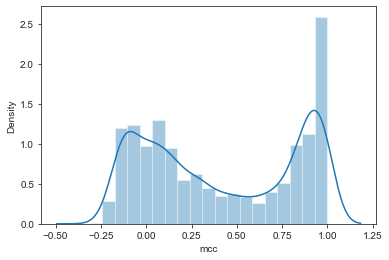

In [4]:
ax = sns.distplot(df["mcc"])

/Users/johannes.ostner/opt/anaconda3/envs/scCoDa/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


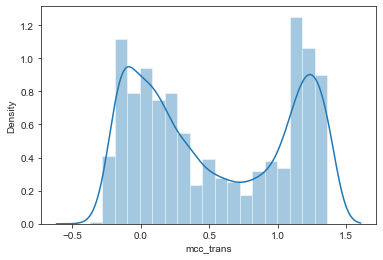

In [5]:
ax = sns.distplot(df["mcc_trans"])

/Users/johannes.ostner/opt/anaconda3/envs/scCoDa/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


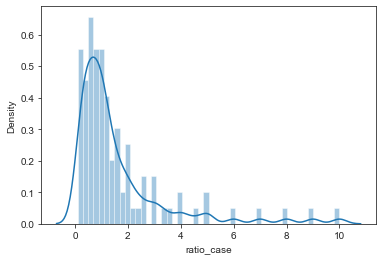

In [6]:
ax = sns.distplot(df["ratio_case"])

In [7]:
# Select out potentially interesting covariates and save as csv for R
df = df[[ "mcc_trans",  "ratio_case",  "total_samples", "log-fold increase", "log_increase"]]
df.to_csv("./mcc_data_for_r_new_data.csv")

We now use the *caret* package in R to perform a backward model selection with repeated 10-fold cross-validation
to determine the significant covariates and their regression parameters.

In [8]:
%%R -i df

# R cell regression analysis and backwards selection
library(caret)
library(leaps)

df = read.csv2("mcc_data_for_r_new_data.csv", sep=",", header = TRUE, dec = ".")
df <- df[-1]
df

train.control <- trainControl(method = "repeatedcv", number = 10, repeats=5)
# Train the model
step.model <- train(mcc_trans ~ (.)**2, 
                    data = df,
                    method = "leapBackward", 
                    tuneGrid = data.frame(nvmax = 1:4),
                    trControl = train.control
)
step.model$results
summary(step.model$finalModel)
coef(step.model$finalModel, step.model$bestTune[[1]])

R[write to console]: Loading required package: lattice

R[write to console]: Loading required package: ggplot2



                   (Intercept)                  total_samples 
                   -1.36756139                     0.01931590 
             log.fold.increase                   log_increase 
                    0.70472954                     0.31585716 
log.fold.increase:log_increase 
                   -0.09279557 


With these parameters, we can predict for a fixed MCC and any effect size the total number of samples needed to expectedly reach this result.

The plot shows exacly this prediction for an MCC of 0.8.

In [9]:
def one_des_mcc(mcc_desired, base, lf_inc):
    """ 
    calculates the number of required samples for 
    fixed MCC base increase and log-fold change using the fitted linear model


    (Intercept)
        -1.3675613850217
    total_samples
        0.0193158965178381
    log_fold_increase
        0.704729538709909
    log_increase
        0.315857162659738
    log_fold_increase:log_increase
        -0.0927955725385892
    """
    
    # scale and transform input features
    mscale_min = 0.3440976088844191
    scaled_mcc = (mcc_desired+1)/2
    scaled_mcc = np.log((scaled_mcc+mscale_min)/(1-scaled_mcc+mscale_min))
    base = base*5000
    inc = base*(2**lf_inc)
    log_inc = np.log(inc)
    
    # invers regress sample size
    increase_effects = 0.704729538709909  * lf_inc + 0.315857162659738 * log_inc - 0.0927955725385892  * lf_inc * log_inc
    nof_sample = (scaled_mcc + 1.3675613850217 - increase_effects) /0.0193158965178381
    nof_sample[nof_sample< 0] = 0
    nof_sample[0.0927955725385892  * lf_inc * log_inc > scaled_mcc + 1.3675613850217] = 0
    return np.round(nof_sample)

In [10]:
#Power analysis plot

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s


base_counts = np.arange(10, 1010, 10)
log_fold_inc = np.arange(0, 5.01, 0.01)

X, Y = np.meshgrid(base_counts, log_fold_inc)
X= X/5000
Z = one_des_mcc(0.8, X, Y)

Text(0, 0.5, 'log2-fold Increase')

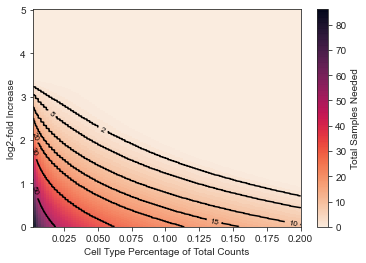

In [11]:
levels=[2,5,10,15,20,30,50]
#
contours = plt.contour(X, Y, Z,  levels=levels,  origin="upper", colors='black')
plt.clabel(contours, contours.levels, inline=True, fontsize=8, fmt="%1.0f")


plt.imshow(Z, origin='lower',interpolation="none",extent=[ min(base_counts/5000),max(base_counts/5000), 0,5.01,],
           cmap=sns.cm.rocket_r, alpha=0.9, aspect='auto')

plt.colorbar(label="Total Samples Needed")
plt.xlabel("Cell Type Percentage of Total Counts")
plt.ylabel("log2-fold Increase")
# plt.savefig("power_analysis_logit_reg.pdf")